[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CCS-ZCU/EuPaC_shared/blob/master/SCRIPTUM_getting-started.ipynb)

This Jupyter notebook has been prepared for the EuPaC Hackathon and provides an easy way to start working with the SCRIPTUM dataset — no need to clone the entire repository or download additional data. It is fully compatible with cloud platforms like Google Colaboratory (click the badge above) and runs without requiring any specialized library installations.

As such, it is intended as a starting point for EuPaC participants, including those with minimal coding experience.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import nltk
import os
from wordcloud import WordCloud
import json
import io

This jupyter notebook consists of three sections. In the first part, you are guided through loading a metadata spreadsheet file containing all crucial metadata about the textual files covered by the SCRIPTUM project.

In the second part, you get a basic demonstration on how to load raw texts of specific documents from SCRIPTUM, based on the metadata. For instance, you can load all texts from a certain journal or a certain year.

In the final part, the same process is repeated, but this time with textual data automatically preprocessed and filtered - each document is represented as a list of lines, with each line representing one (automatically tokenized) sentence and each sentence contains only filtered lemmata of nouns, verbs, adjectives and proper names. Based on a fully automatized pipeline, these proprocessed are far from perfect and perhaps not available for all documents within the corpus.

# Load and explore metadata

In [2]:
scriptum_df = pd.read_json("https://raw.githubusercontent.com/CCS-ZCU/scriptum/refs/heads/master/data/files_df.json")

In [3]:
scriptum_df.head(5)

,periodical_category,periodical_href,periodical_title,periodical_basic_info,file_url,filename,year,pages_N,tokens_N
0,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1986_2_vina_ocr.txt,1986.0,36,24524
1,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1987_3_freud-a-psychoanalyza_ocr.txt,1987.0,42,21575
2,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1988_4_sluzba-zivotu_rok-blahoslavene-anez...,1988.0,25,14764
3,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1989_5_vira-v-modernim-svete_ocr.txt,1989.0,36,23867
4,samizdat,/cs/periodika/abecedni-casopis,Abecední časopis,"[, Praha , 1985 - 1986 , nepravidelně , ]",https://files.scriptum.cz/scriptum/abecedni-ca...,abecedni-casopis_1986_2_bonifac_tit-str-obsah_...,1986.0,2,87


In [4]:
scriptum_df["pages_N"].sum()

np.int64(318091)

In [5]:
scriptum_df["tokens_N"].sum()

np.int64(225246206)

In [6]:
scriptum_df["tokens_N"].sum() / scriptum_df["pages_N"].sum()

np.float64(708.1187647559975)

In [7]:
scriptum_df[scriptum_df["periodical_category"]=="samizdat"]["tokens_N"].sum()

np.int64(35705928)

In [8]:
len(scriptum_df[scriptum_df["periodical_category"]=="samizdat"])

2324

In [9]:
scriptum_df[scriptum_df["periodical_category"]=="exil"]["tokens_N"].sum()

np.int64(189540278)

In [10]:
len(scriptum_df[scriptum_df["periodical_category"]=="exil"])

9290

[Text(0, 0, '0M'),
 Text(0, 50000000, '50M'),
 Text(0, 100000000, '100M'),
 Text(0, 150000000, '150M')]

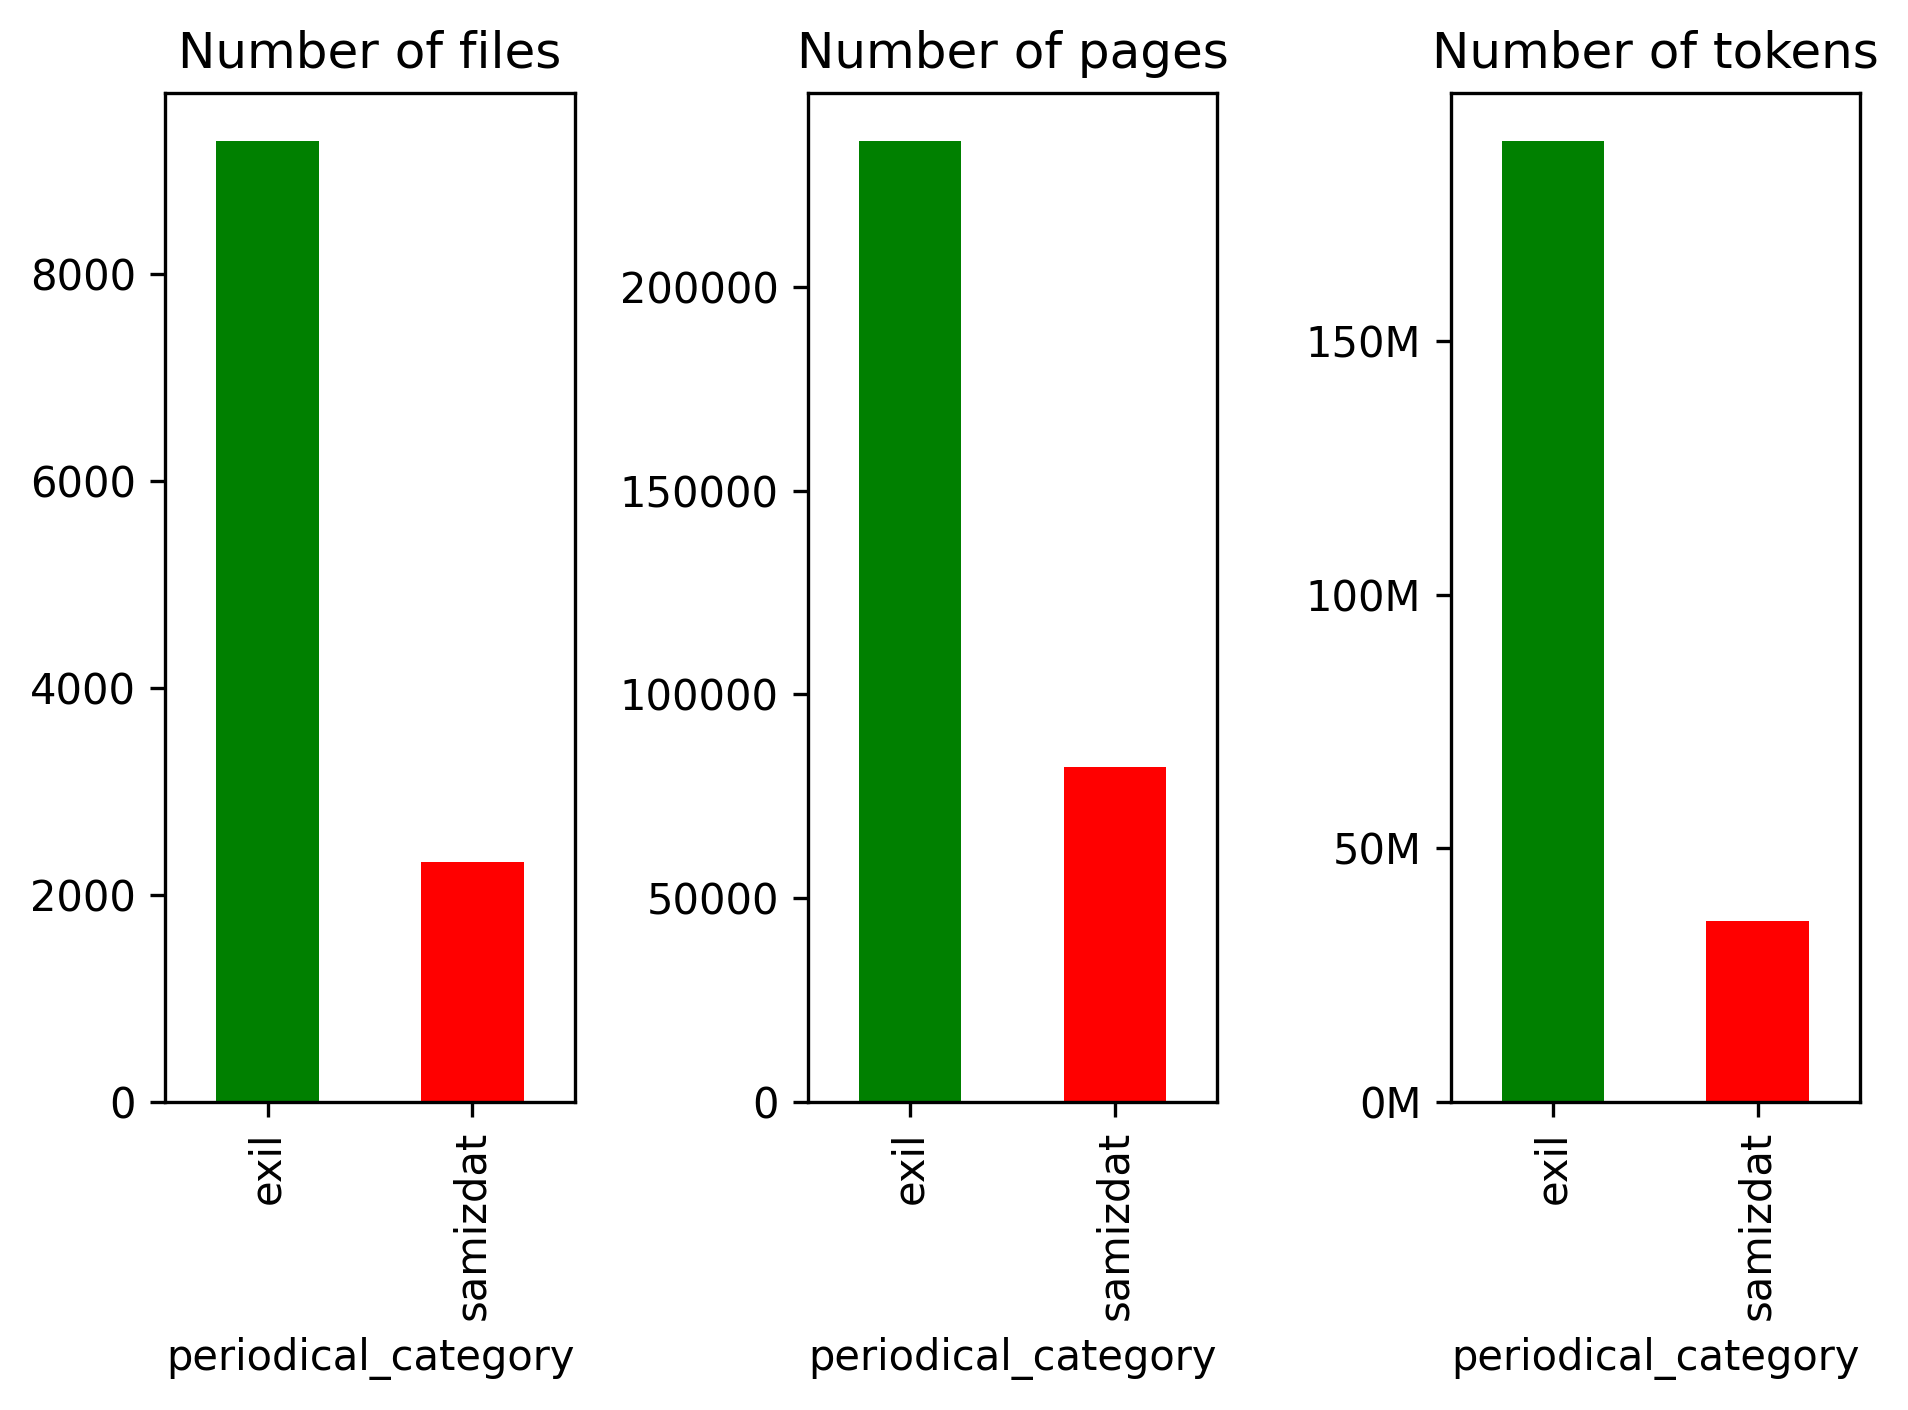

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, dpi=300, tight_layout=True)
scriptum_df.groupby("periodical_category").size().plot(kind='bar', color=["green", "red"], ax=axs[0])
scriptum_df.groupby("periodical_category")["pages_N"].sum().plot(kind='bar', color=["green", "red"], ax=axs[1])
scriptum_df.groupby("periodical_category")["tokens_N"].sum().plot(kind='bar', color=["green", "red"], ax=axs[2])

axs[0].set_title("Number of files")
axs[1].set_title("Number of pages")
axs[2].set_title("Number of tokens")


axs[2].set_yticks(range(0,200000000, 50000000))
axs[2].set_yticklabels([str(n)+ "M" for n in range(0,200, 50)])

In [12]:
sum(scriptum_df["year"].apply(lambda x: 1948 <= x <= 1989))

8745

In [13]:
scriptum_df["communism"] = scriptum_df["year"].apply(lambda x: 1948 <= x <= 1989)

[Text(0, 0, '0M'),
 Text(0, 50000000, '50M'),
 Text(0, 100000000, '100M'),
 Text(0, 150000000, '150M')]

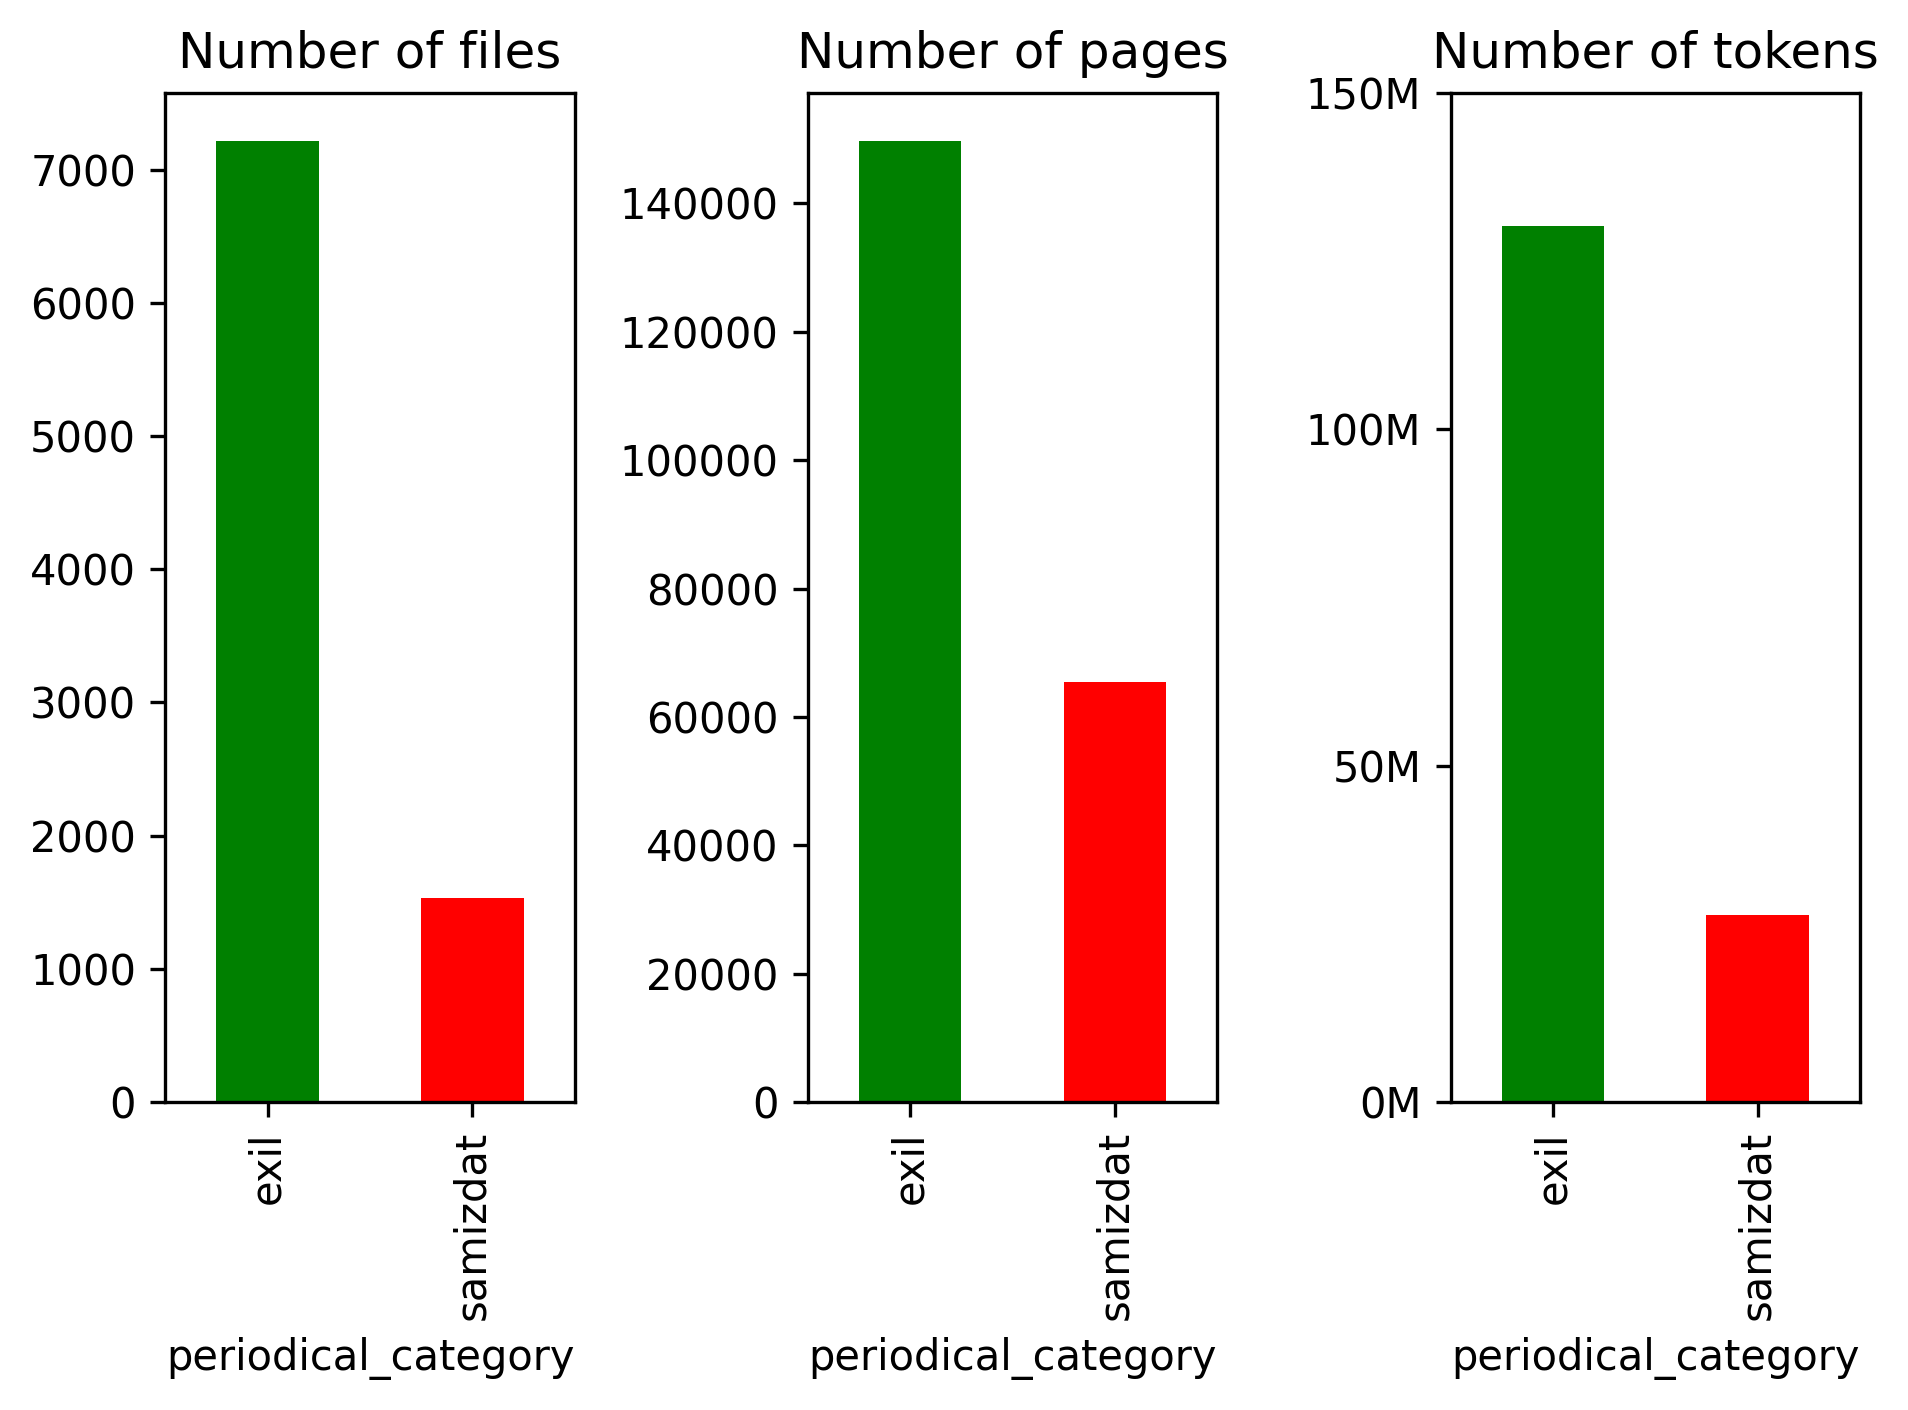

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, dpi=300, tight_layout=True)
scriptum_df[scriptum_df["communism"]].groupby("periodical_category").size().plot(kind='bar', color=["green", "red"], ax=axs[0])
scriptum_df[scriptum_df["communism"]].groupby("periodical_category")["pages_N"].sum().plot(kind='bar', color=["green", "red"], ax=axs[1])
scriptum_df[scriptum_df["communism"]].groupby("periodical_category")["tokens_N"].sum().plot(kind='bar', color=["green", "red"], ax=axs[2])

axs[0].set_title("Number of files")
axs[1].set_title("Number of pages")
axs[2].set_title("Number of tokens")


axs[2].set_yticks(range(0,200000000, 50000000))
axs[2].set_yticklabels([str(n)+ "M" for n in range(0,200, 50)])

### Temporal overview

In [32]:
decade_bins = np.arange(1940, 2000, 10)
decades_labels = ["40th", "50th", "60th", "70th", "80th"]
decade_bins

array([1940, 1950, 1960, 1970, 1980, 1990])

[Text(0, 0, '0M'),
 Text(0, 20000000, '20M'),
 Text(0, 40000000, '40M'),
 Text(0, 60000000, '60M'),
 Text(0, 80000000, '80M')]

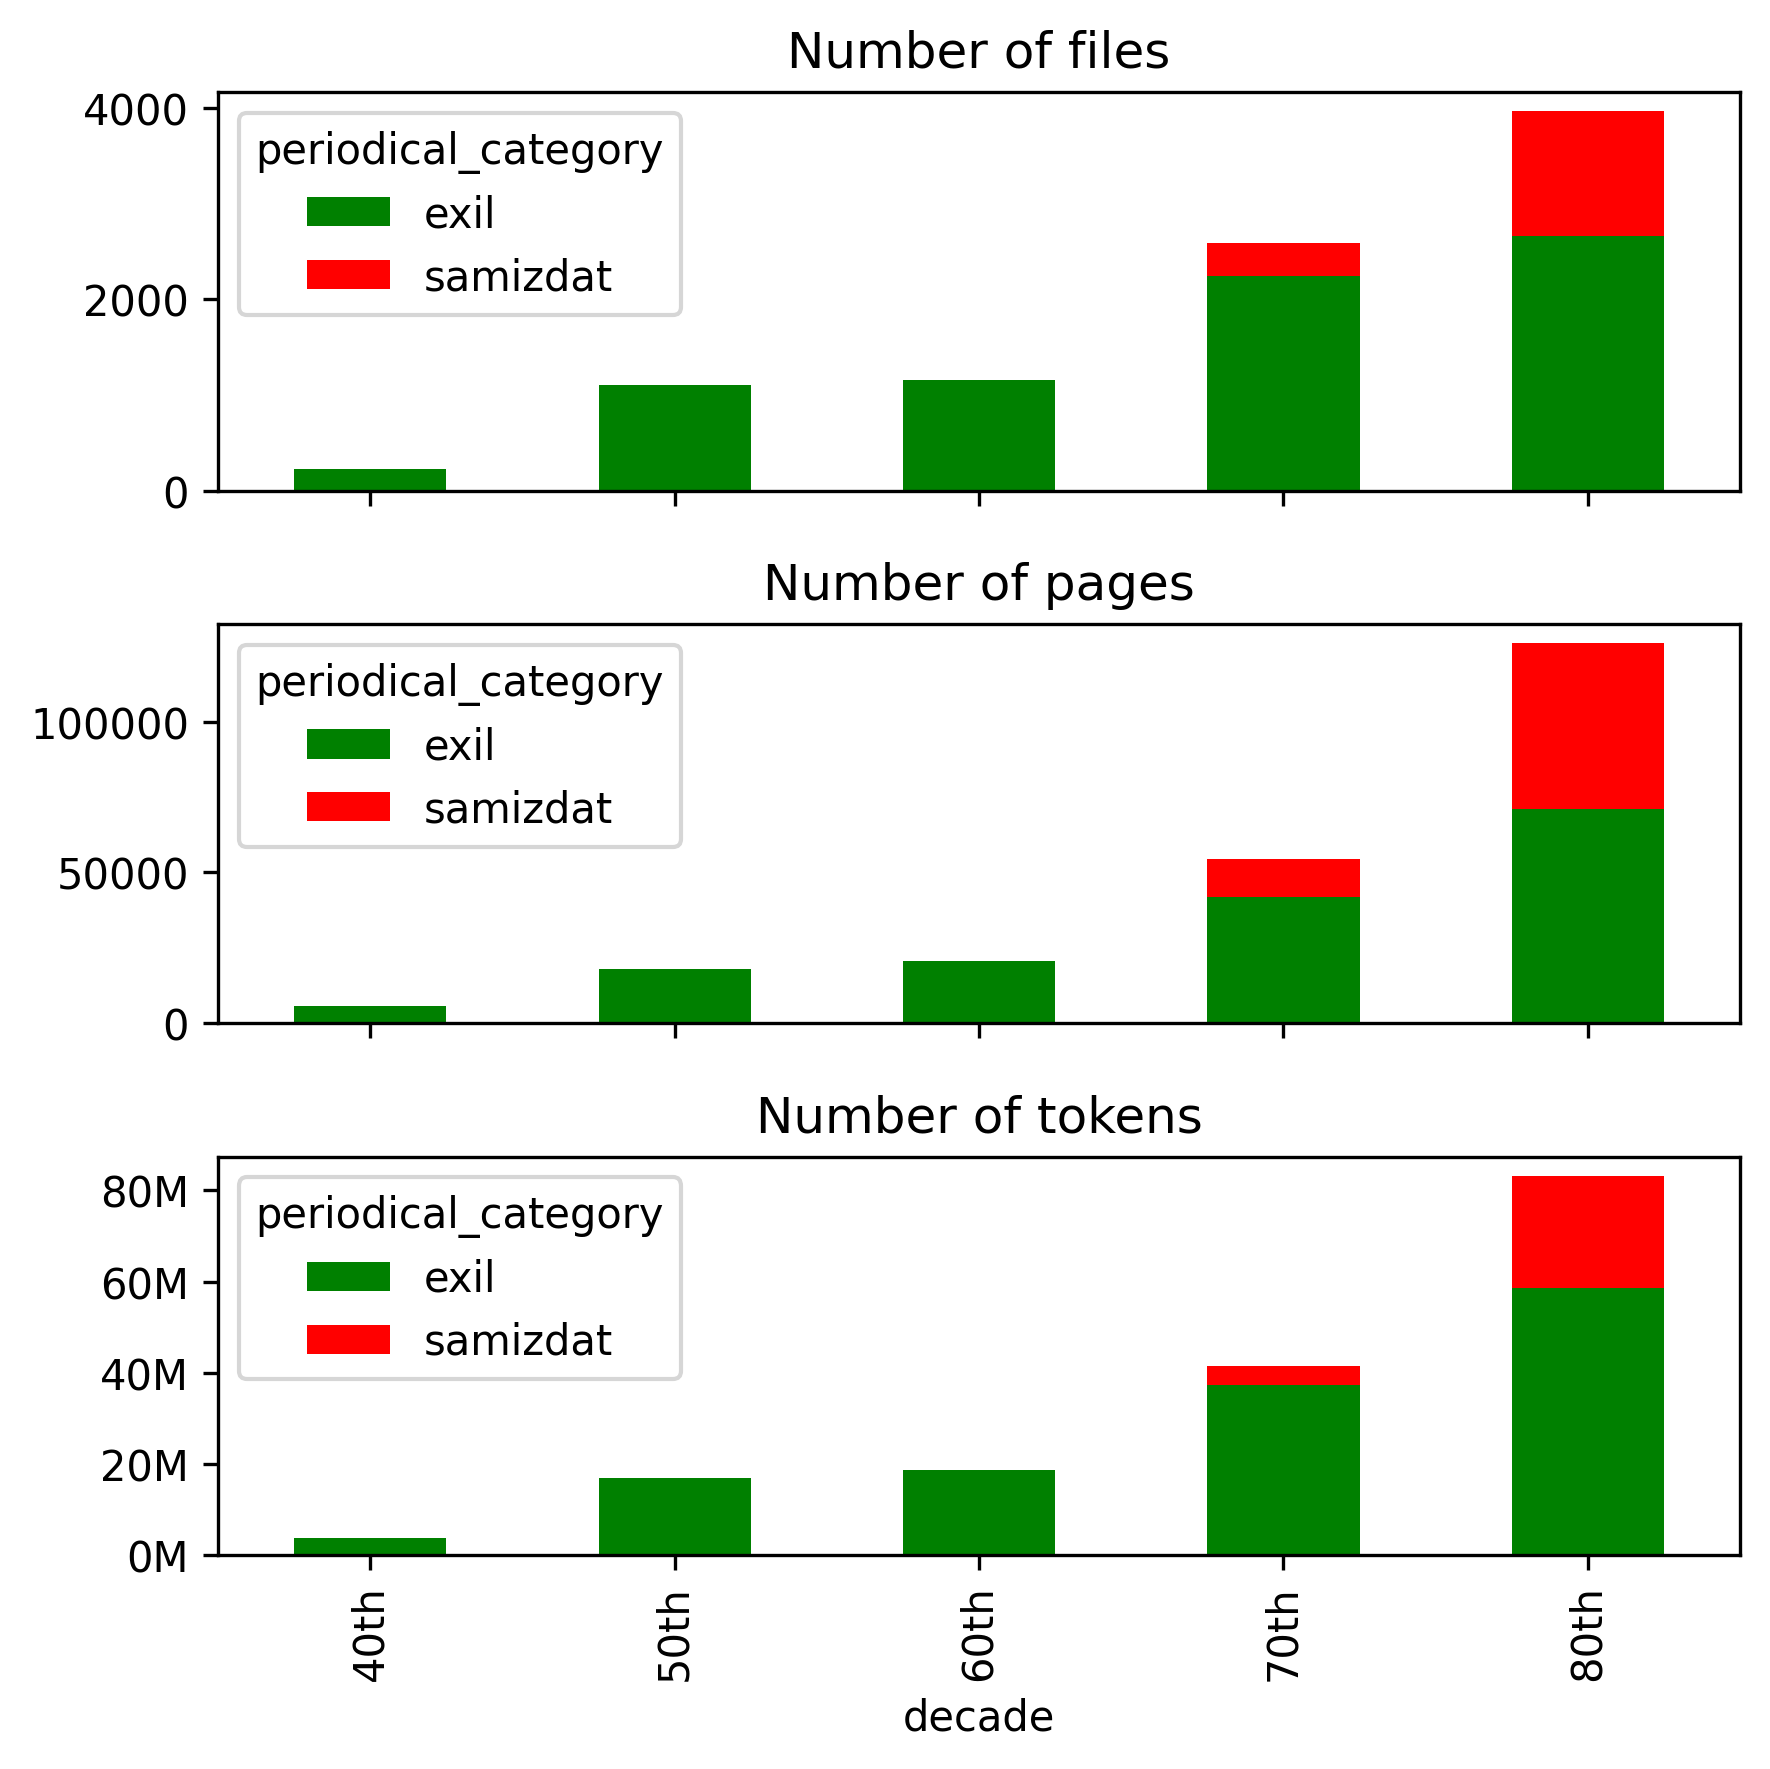

In [33]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,6), dpi=300, tight_layout=True)
decade_bins = np.arange(1940, 2000, 10)
periodical_decade_counts = scriptum_df.groupby(['periodical_category', pd.cut(scriptum_df['year'], bins=decade_bins)], observed=True).size()
periodical_decade_counts.unstack(level=0).plot(kind='bar', stacked=True, color=["green", "red"], ax=axs[0])
axs[0].set_title("Number of files")
axs[0].set_xticklabels([])
axs[0].set_xlabel("")

periodical_decade_counts = scriptum_df.groupby(['periodical_category', pd.cut(scriptum_df['year'], bins=decade_bins)], observed=True)["pages_N"].sum()
periodical_decade_counts.unstack(level=0).plot(kind='bar', stacked=True, color=["green", "red"], ax=axs[1])
axs[1].set_title("Number of pages")
axs[1].set_xticklabels([])
axs[1].set_xlabel("")


periodical_decade_counts = scriptum_df.groupby(['periodical_category', pd.cut(scriptum_df['year'], bins=decade_bins)], observed=True)["tokens_N"].sum()
periodical_decade_counts.unstack(level=0).plot(kind='bar', stacked=True, color=["green", "red"], ax=axs[2])
axs[2].set_title("Number of tokens")
axs[2].set_xticklabels(decades_labels)
axs[2].set_xlabel("decade")
axs[2].set_yticks(range(0,100000000, 20000000))
axs[2].set_yticklabels([str(n)+ "M" for n in range(0,100, 20)])


### Most prominent periodicals

In [34]:
scriptum_df = scriptum_df[scriptum_df["periodical_title"]!="Obsah"]
len(scriptum_df)

11526

In [35]:
scriptum_df = scriptum_df[scriptum_df["communism"]]
len(scriptum_df)

8659

[Text(0, 0, '0M'),
 Text(1000000, 0, '1M'),
 Text(2000000, 0, '2M'),
 Text(3000000, 0, '3M')]

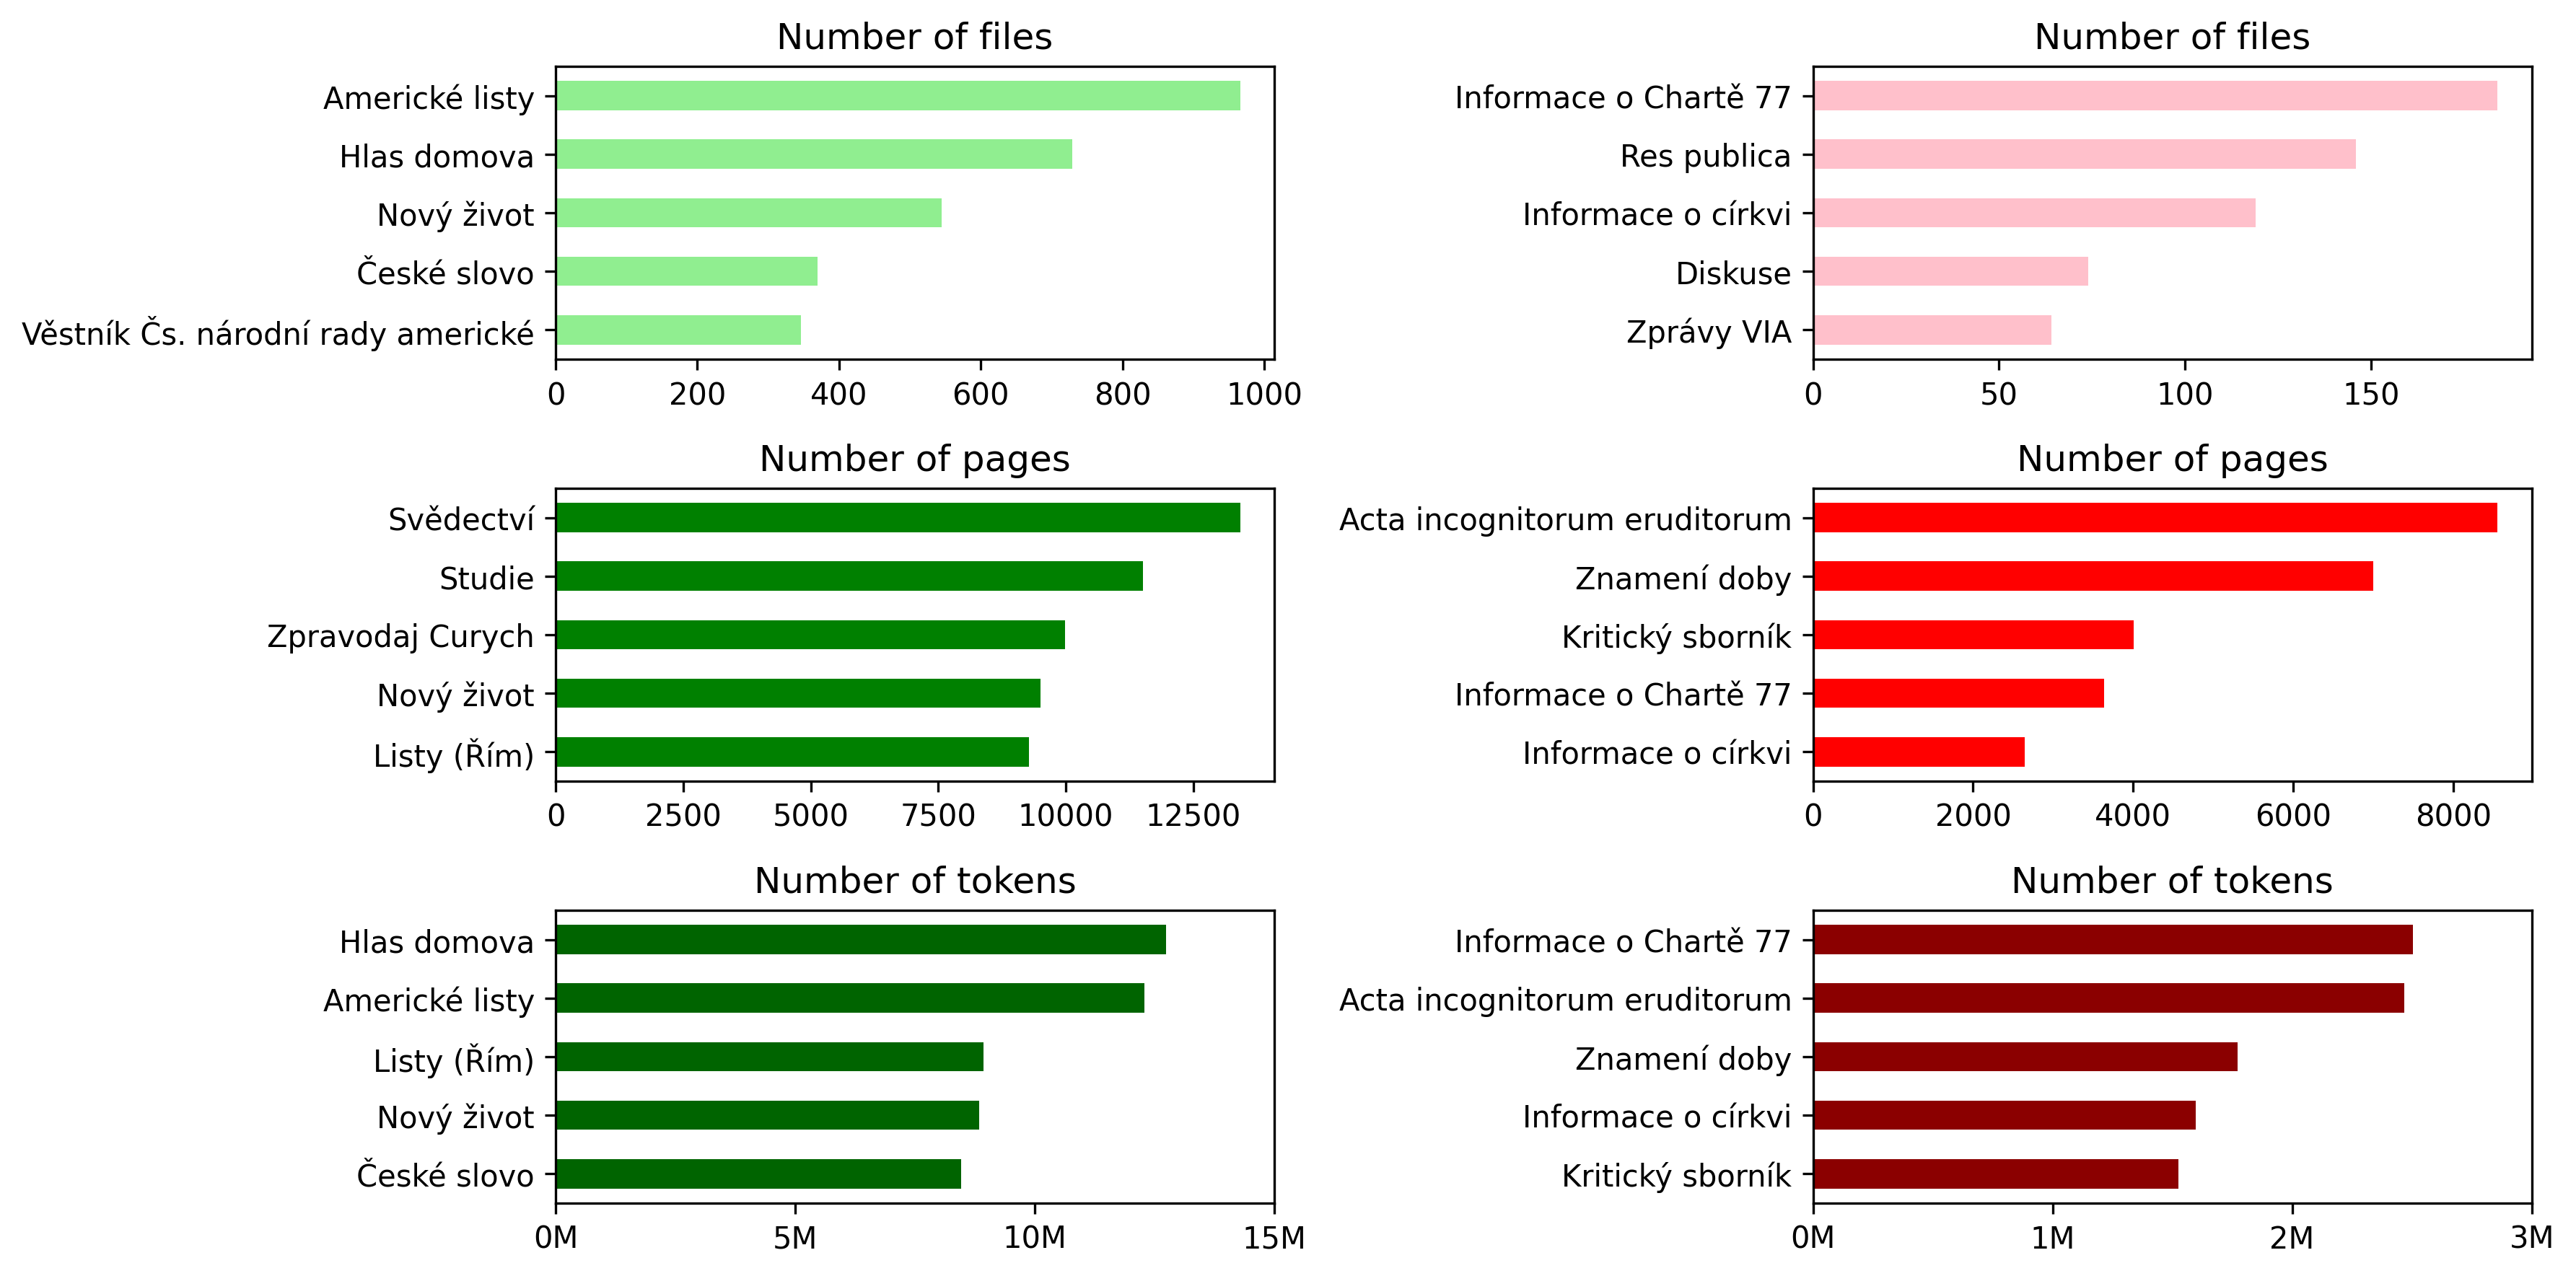

In [36]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,6), dpi=300, tight_layout=True)
scriptum_df[scriptum_df["periodical_category"]=="exil"].groupby("periodical_title").size().sort_values(ascending=True).tail(5).plot(kind='barh', color="lightgreen", ax=axs[0, 0])
axs[0, 0].set_title("Number of files")
axs[0, 0].set_ylabel("")

scriptum_df[scriptum_df["periodical_category"]=="exil"].groupby("periodical_title")["pages_N"].sum().sort_values(ascending=True).tail(5).plot(kind='barh', color="green", ax=axs[1,0])
axs[1, 0].set_title("Number of pages")
axs[1, 0].set_ylabel("")

scriptum_df[scriptum_df["periodical_category"]=="exil"].groupby("periodical_title")["tokens_N"].sum().sort_values(ascending=True).tail(5).plot(kind='barh', color="darkgreen", ax=axs[2,0])
axs[2, 0].set_title("Number of tokens")
axs[2, 0].set_ylabel("")
axs[2, 0].set_xticks(range(0,20000000, 5000000))
axs[2, 0].set_xticklabels([str(n)+ "M" for n in range(0,20, 5)])

scriptum_df[scriptum_df["periodical_category"]=="samizdat"].groupby("periodical_title").size().sort_values(ascending=True).tail(5).plot(kind='barh', color="pink", ax=axs[0, 1])
axs[0, 1].set_title("Number of files")
axs[0, 1].set_ylabel("")

scriptum_df[scriptum_df["periodical_category"]=="samizdat"].groupby("periodical_title")["pages_N"].sum().sort_values(ascending=True).tail(5).plot(kind='barh', color="red", ax=axs[1, 1])
axs[1, 1].set_title("Number of pages")
axs[1, 1].set_ylabel("")

scriptum_df[scriptum_df["periodical_category"]=="samizdat"].groupby("periodical_title")["tokens_N"].sum().sort_values(ascending=True).tail(5).plot(kind='barh', color="darkred", ax=axs[2, 1])
axs[2, 1].set_title("Number of tokens")
axs[2, 1].set_ylabel("")
axs[2, 1].set_xticks(range(0,4000000, 1000000))
axs[2, 1].set_xticklabels([str(n)+ "M" for n in range(0,4)])

# Access the raw texts

This section shows you how to load content of either individual text or a subset of texts based on some metadata.

In [15]:
# if you in mind a specific document you want to explore
dir = "data/rawtexts"
filename = "150000-slov_1983_06_ocr.txt"
url = "https://raw.githubusercontent.com/CCS-ZCU/scriptum/5bdc0262f061eb98029de0c1b77e5969c5407073/{0}/{1}".format(dir,filename)
resp = requests.get(url)
doc_text = resp.text
doc_text[:1000]

'150000 SLOV Socialistická ideologie myslící jenom v tunách, a vysoká tempa růstu způsobila zkázu životního prostředí, jaká nemá v Evropě obdoby: V ČSSRje 34 procent lesů těžce postiženo, či dokonce již zcela zničeno. Lidé strádají znečištěním ovzduší a vody daleko více, než kdekoli jinde. Ale o nějakém zlepšení situace nemůže být řeči: ČSSR své elektrárny na hnědé uhlí potřebuje a informace o znečištěni životního prostředí se taji. Čtyři milióny Čechů a Slováků - 26 procent obyvatelstva státu - žijí v ovzduší zamořeném na nej- vyšší stupeň. Slunce vidí pouze v hustém červeno- hnědém oparu plynových zplodin. 33 procent říčních toků v Československu - t.zn. více než 8000 kilometrů - jsou již biologicky mrtvé. 500.000 hektarů lesa na území ČSSR se považuje za těžce ekologicky poškozené. V roce 1990 bude tímto způsobem postiženo jeden milión hektarů lesa, tzn. 34,5 procent všech lesů v Československu. Přinejmenším v jednom směru dosáhla ČSSR pod vedením stranického předsedy a hlavy státu 

In [17]:
# you can also load textual data based on specific metadata criteria
metadata_subset = scriptum_df[(scriptum_df["year"].between(1970,1975)) & (scriptum_df["periodical_category"]=="samizdat")]

In [18]:
subset_rawtexts = []
dir = "data/rawtexts"
for filename in metadata_subset["filename"]:
    url = "https://raw.githubusercontent.com/CCS-ZCU/scriptum/5bdc0262f061eb98029de0c1b77e5969c5407073/{0}/{1}".format(dir,filename)
    try:
        doc_text = requests.get(url).text
    except:
        doc_text = ""
    subset_rawtexts.append(doc_text)

In [19]:
# now you have a list of raw texts from your selected documents within a list
# these texts can be easily mapped back on your subset of filtered metadata, as they keep the same shape:
# but some of the texts might not be available..
# for instance, here is the beginning of your third document:
subset_rawtexts[2][:2000]

'DOUTNÍK ill (Prácovhľ sborn íkl Breton Prassiaosová Pičabia CärringtonovÄ Benayoun Lyle Jany [pageend1]Obsah André Breton - Hromosvod /předmluva k Antologii černého humoru/ Gisela Prassinosová - Sbírka údů Francis Picabia - Studené oko -"- - Pětitiminutová mezihra -"- - Dítě Leonora Carringtonová - Za čátečníce André Breton - Leonora Carringtonová Petr Král- Hučet do špeku -"- - Yardley - kapradí Robert Benayoun - Zkrvavené M arie Z korespondence Pavel Řezníček: Moře -"- - Konec starého mistra -"- - Výpravčí Pavel Řezníček - Dobrý den Jan Gabriel - Fibrom -"- - Prohlídka -"- - Výlet -"- - Harakiri -"- - Na výzvědách John Lyle: Humor ve službě revoluce V.E.Mencl — Řeky a moře /fragment/ Pavel Řezníček - Křižácká výprava -"- - M agistr farmacie -"- Opera -"- - Jen několik zvíŕat umí pískat na prsty, Já to nejsem Alfred Jarry - Kristovo utrpení pojaté jako cyklistický závod. André Breton - Jacques Rigaut Jacques Rigaut - Budu vážný jako slast.... Alberto Savinie - Úvod do života rtuti La

# Access lemmatized texts

The sents_data is a list of sentences from the given document accompanied by morphological annotations and lemmata for individual tokens.

For each sentence, you see the following elements:
* (1) name of the source text fild
* (2) raw text of the sentence
* (2) token data for the sentence
The token data for each token contain:
   * (a) The token as it is in the sentence
   * (b) The automatically assigned lemma corresponding to the token
   * (c) Its Part-of-Speech
   * (d) Its starting positional index within the sentence
   * (e) Its ending positional index within the sentence


In [44]:
# load an example sentence data file:
filename = "americke-listy_1977_11-11_45_ocr.json"
base_url = "https://ccs-lab.zcu.cz/scriptum_sents_data/"
f_sents_data = json.load(io.BytesIO(requests.get(base_url + filename).content))

In [45]:
# look at a slice of the data:
f_sents_data[10:15]

[['americke-listy_1977_11-11_45_ocr.txt',
  'Tím byl pražský proces dostatečné ospravedlněn .',
  [['Tím', 'ten', 'DET', [0, 3]],
   ['byl', 'být', 'AUX', [4, 7]],
   ['pražský', 'pražský', 'ADJ', [8, 15]],
   ['proces', 'proces', 'NOUN', [16, 22]],
   ['dostatečné', 'dostatečný', 'ADJ', [23, 33]],
   ['ospravedlněn', 'ospravedlněný', 'ADJ', [34, 46]],
   ['.', '.', 'PUNCT', [47, 48]]]],
 ['americke-listy_1977_11-11_45_ocr.txt',
  '. .',
  [['.', '.', 'PUNCT', [0, 1]], ['.', '.', 'PUNCT', [2, 3]]]],
 ['americke-listy_1977_11-11_45_ocr.txt',
  'Zřejmě přechodná zadržení či zatčení přátel čtyř obžalovaných r jejich bytech nebo na cestě k pražskému městskému soudu či přímo v soudní budově jsou vědomě a poživačně insci novaná sebeobnažení jednoho evropského outsidera, který se bezostyšně posmívá konvencím, morálce i slušnosti.',
  [['Zřejmě', 'zřejmě', 'ADV', [0, 6]],
   ['přechodná', 'přechodný', 'ADJ', [7, 16]],
   ['zadržení', 'zadržení', 'NOUN', [17, 25]],
   ['či', 'či', 'CCONJ', [26,

In [20]:
#
scriptum_df["filename"].tolist()[:100]

['psi_1986_2_vina_ocr.txt',
 'psi_1987_3_freud-a-psychoanalyza_ocr.txt',
 'psi_1988_4_sluzba-zivotu_rok-blahoslavene-anezky_ocr.txt',
 'psi_1989_5_vira-v-modernim-svete_ocr.txt',
 'abecedni-casopis_1986_2_bonifac_tit-str-obsah_ocr.txt',
 'abecedni-casopis_1986_3_drozd_tit-str-obsah_ocr.txt',
 'abecedni-casopis_1986_4_cestmir_tit-str-obsah_ocr.txt',
 'acta-incognitorum_1976_r01_01-02_ocr.txt',
 'acta-incognitorum_02_1976_01-02_ocr.txt',
 'acta-incognitorum_1976-77_r02_03-04_ocr.txt',
 'acta-incognitorum_1976-77_r02_05-07_ocr.txt',
 'acta-incognitorum_1976-77_r02_08-10_ocr.txt',
 'acta-incognitorum_1976-77_r02_11_ocr.txt',
 'acta-incognitorum_1977-78_r03_01-04_ocr.txt',
 'acta-incognitorum_1978_r03_05-07_ocr.txt',
 'acta-incognitorum_1977-78_r03_08-10_ocr.txt',
 'acta-incognitorum_1978-79_r04_01-05_ocr.txt',
 'acta-incognitorum_1978-79_r04_06-10_ocr.txt',
 'acta-incognitorum_1979-80_r05_01-05_ocr.txt',
 'acta-incognitorum_1980_r05_06-11_ocr.txt',
 'acta-incognitorum_1980-81_r06_01-05_ocr

In [ ]:
subset_lemmatized_sentences = []
for id in ids: # for each work ID from our subset of IDs
    f_sents_data = json.load(io.BytesIO(requests.get(base_url.format(str(id))).content))
    sents_n = len(f_sents_data)
    for sent_data in f_sents_data:
        sent_lemmata = [t[1] for t in sent_data[3] if t[2] in ["NOUN", "VERB", "ADJ", "PROPN"]] # filter for specific POS-tags
        sent_lemmata = [re.sub(r"\W*|\d*", "", t) for t in sent_lemmata] # remove all non-alphanumeric characters
        sent_lemmata = [l for l in sent_lemmata if len(l) > 1] # remove all one-letter words
        sent_lemmata = [l.lower() for l in sent_lemmata] # lowercase all words
        subset_lemmatized_sentences.append(sent_lemmata) # add the lemmatized words from the current sentence to the overall list of lemmatized words

In [28]:
len(file_list)

1000

In [22]:
def load_lemmatized_sentences(filename, base_url="https://raw.githubusercontent.com/CCS-ZCU/scriptum/5bdc0262f061eb98029de0c1b77e5969c5407073/{0}/{1}", dir="data/lemsents"):
    url = base_url.format(dir,filename)
    resp = requests.get(url)
    if resp.ok:
        doc_text = requests.get(url).text
    else:
        doc_text = ""
    lemmatized_sents = [[lemma for lemma in sent.split()] for sent in doc_text.split("\n")]
    return lemmatized_sents

In [51]:
# again, you can load sentence data based on specific metadata criteria
metadata_subset = scriptum_df[(scriptum_df["year"].between(1970,1985)) & (scriptum_df["periodical_category"]=="samizdat")]

In [52]:
sents_data = []
base_url = "https://ccs-lab.zcu.cz/scriptum_sents_data/"
for filename in metadata_subset["filename"]:
    # the lemmatized data are currently available for approx. 80% of texts
    try:
        f_sents_data = json.load(io.BytesIO(requests.get(base_url + filename.replace(".txt", ".json")).content))
        sents_data.extend(f_sents_data)
    except:
        pass

In [54]:
len(sents_data)

397510

In [60]:
lemmatized_sentences = []
for sent_data in sents_data:
    lemmatized_sent = [token[1] for token in sent_data[2] if token[2] in ["NOUN", "VERB", "ADJ", "PROPN"]]
    lemmatized_sentences.append(lemmatized_sent)

In [61]:
lemmatized_sentences[10:15]

[['chtít', 'ukázat', 'vytvoření', 'společnost', 'viset', 'vzduch', 'spadnutí'],
 ['rozpuštění',
  'CSN',
  'přetvořený',
  'písecký',
  'pospolitost',
  'vzniknout',
  'prostor',
  'muset',
  'vyplněný',
  'chtít',
  'scházet'],
 ['konverzace',
  'Leo',
  'salon',
  'dostávat',
  'těthh',
  'kolej',
  'obzor',
  'šířit'],
 ['trpět', 'účast', 'přestávat', 'považovat', 'přínos'],
 ['zřejmý',
  'konání',
  'oživit',
  'vnést',
  'jistý',
  'řád',
  'zaručovat',
  'pevný',
  'program']]

In [63]:
# to get a flat list of lemmata from all documents in a subset:
lemmata_list = [lemma for sent in lemmatized_sentences for lemma in sent]
# calculate the frequency of each lemma with nltk:
lemmata_freqs = nltk.FreqDist(lemmata_list).most_common()
lemmata_freqs[:10]

[('t', 46649),
 ('e', 36423),
 ('mít', 35612),
 ('rok', 35595),
 ('litr', 24171),
 ('n', 24102),
 ('moci', 21774),
 ('j', 17163),
 ('c', 15183),
 ('podnik', 12510)]

In [64]:
# you can then proceed to a comparison across periods or other subsets of texts
periods_freqs = {}
periods = [(1960,1964), (1965,1969), (1970,1974)]
periods_labels = ["Scriptum {0}-{1}".format(str(period[0]), str(period[1])) for period in periods]
for period, period_label in zip(periods, periods_labels):
    subset_df = scriptum_df[scriptum_df["year"].between(period[0], period[1])]
    sents_data = []
    base_url = "https://ccs-lab.zcu.cz/scriptum_sents_data/"
    for filename in metadata_subset["filename"]:
        # the lemmatized data are currently available for approx. 80% of texts
        try:
            f_sents_data = json.load(io.BytesIO(requests.get(base_url + filename.replace(".txt", ".json")).content))
            sents_data.extend(f_sents_data)
        except:
            pass
    lemmatized_sentences = []
    for sent_data in sents_data:
        lemmatized_sent = [token[1] for token in sent_data[2] if token[2] in ["NOUN", "VERB", "ADJ", "PROPN"]]
        lemmatized_sentences.append(lemmatized_sent)
    lemmata_list = [lemma for sent in lemmatized_sentences for lemma in sent]
    lemmata_list = [lemma for lemma in lemmata_list if len(lemma) > 1]
    lemmata_freqs = nltk.FreqDist(lemmata_list).most_common()
    periods_freqs[period_label] = lemmata_freqs

In [65]:
# check frequencies for a specific period:
periods_freqs["Scriptum 1960-1964"][:10]

[('mít', 35612),
 ('rok', 35595),
 ('litr', 24171),
 ('moci', 21774),
 ('podnik', 12510),
 ('stát', 12426),
 ('život', 12377),
 ('společnost', 11024),
 ('lidé', 10991),
 ('jít', 10720)]

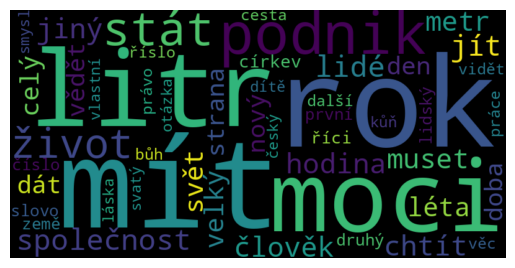

In [66]:
# plot the freuquencies for a specific period:
wc = WordCloud(width=800, height=400).generate_from_frequencies(dict(periods_freqs[periods_labels[0]][:50]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

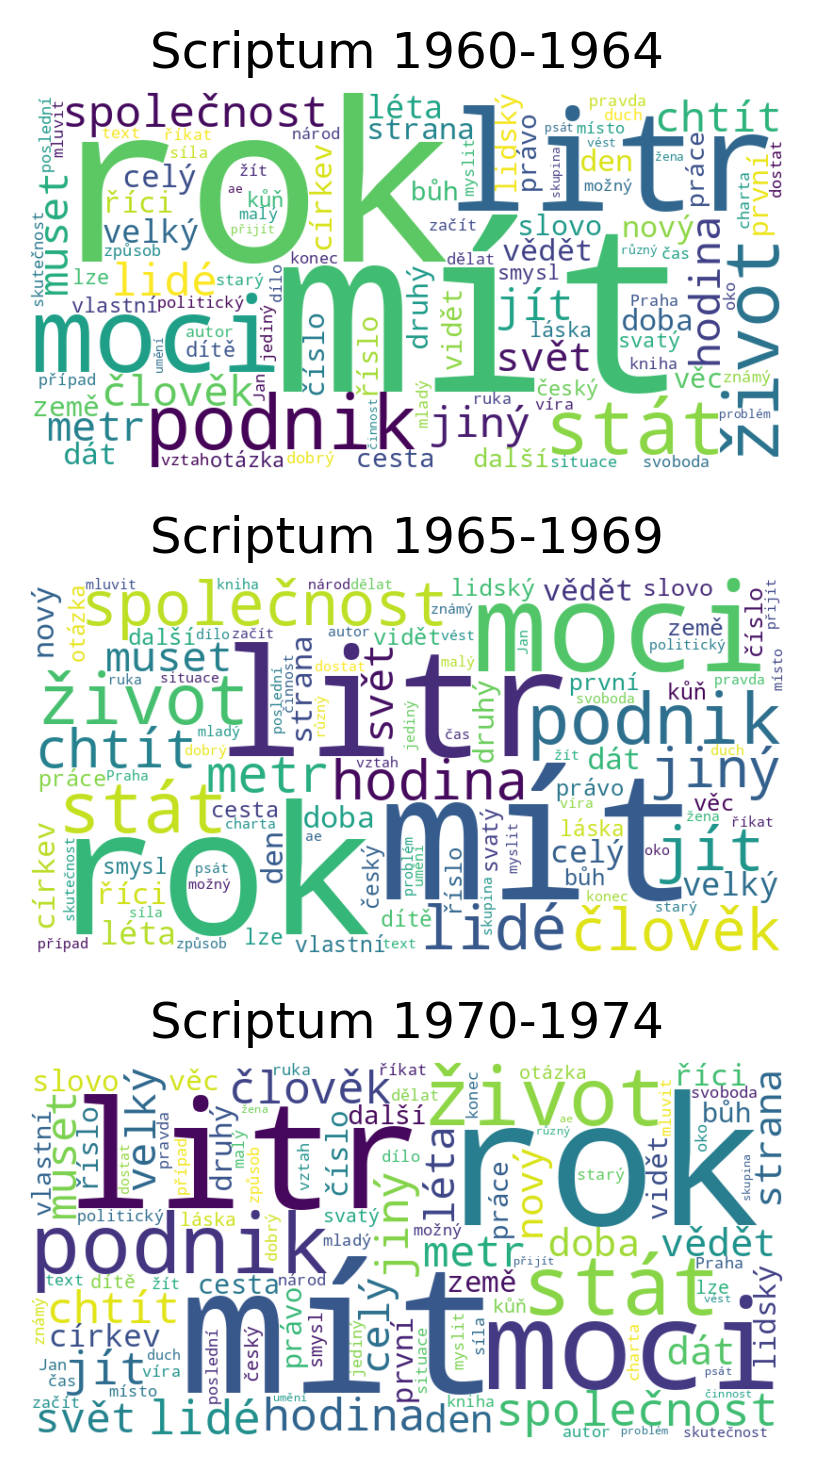

In [67]:
n = 100
fig, axs = plt.subplots(3,1, figsize=(4.5, 5) , dpi=300, tight_layout=True)
for item, ax in zip(periods_freqs.items(), axs.ravel()):
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(item[1][:n]))
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(item[0])
    ax.axis("off")